In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Set the working directory to the location of this script
print("Current working directory:", os.getcwd())

# Define base path for data files
base_path = os.path.expanduser("~/work/vaping_project_data/original_all_core")

# Create data files dictionary with more readable structure
data_files = {
    f"c{str(year)[-2:]}_{period}": os.path.join(base_path, f"original_core_{year}_{period}.tsv")
    for year in range(2017, 2024)
    for period in ["0012", "0810"]
}

# Load datasets with error handling
dfs = {}
for key, filepath in data_files.items():
    try:
        dfs[key] = pd.read_csv(filepath, sep='\t', low_memory=False)
        print(f"Loaded {key} with shape {dfs[key].shape}")
    except Exception as e:
        print(f"Error loading {key} from {filepath}: {e}")

# Create summary table for all datasets
summary_data = []
for key, df in dfs.items():
    # Count numerical and categorical columns
    numerical_cols = len(df.select_dtypes(include=['int64', 'float64']).columns)
    categorical_cols = len(df.select_dtypes(include=['object', 'category']).columns)
    
    summary_data.append({
        'Dataset': key,
        'Shape': df.shape,
        'Columns': len(df.columns),
        'Numerical Columns': numerical_cols,
        'Categorical Columns': categorical_cols,
        'Missing Values': df.isnull().sum().sum(),
        'Memory Usage': f"{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB"
    })

# Create and display summary DataFrame
summary_df = pd.DataFrame(summary_data)
print("\nDataset Summary:")
print(summary_df.to_string(index=False))


Current working directory: /home/siyang/vaping_project
Loaded c17_0012 with shape (13522, 184)
Loaded c17_0810 with shape (30181, 581)
Loaded c18_0012 with shape (14502, 184)
Loaded c18_0810 with shape (29980, 583)
Loaded c19_0012 with shape (13713, 217)
Loaded c19_0810 with shape (28818, 628)
Loaded c20_0012 with shape (3770, 202)
Loaded c20_0810 with shape (8051, 635)
Loaded c21_0012 with shape (9022, 232)
Loaded c21_0810 with shape (23238, 695)
Loaded c22_0012 with shape (9599, 197)
Loaded c22_0810 with shape (21839, 663)
Loaded c23_0012 with shape (7584, 198)
Loaded c23_0810 with shape (14734, 655)

Dataset Summary:
 Dataset        Shape  Columns  Numerical Columns  Categorical Columns  Missing Values Memory Usage
c17_0012 (13522, 184)      184                184                    0               0     18.98 MB
c17_0810 (30181, 581)      581                581                    0               0    133.78 MB
c18_0012 (14502, 184)      184                184                    0  

In [5]:
def transform_nicotine(df, old_var):
    """
    Create a new column 'nicotine12' from the given old variable
    and drop the original column.
    """
    df = df.copy()
    df['nicotine12'] = df[old_var]
    df.drop(columns=[old_var], inplace=True)
    return df

def calculate_frequency(df, tibble_name):
    """
    Calculate count and percentage for the 'nicotine12' column.
    Adds the tibble name as a column.
    """
    freq = df['nicotine12'].value_counts(dropna=False).reset_index()
    freq.columns = ['nicotine12', 'n']
    freq['Percentage'] = freq['n'] / freq['n'].sum() * 100
    freq.insert(0, 'tibble', tibble_name)
    return freq

def add_grade_column(df, tibble_name):
    """
    For datasets ending with "0810", add a 'grade' column by copying V501 and drop V501.
    """
    df = df.copy()
    if tibble_name.endswith("0810"):
        df['grade'] = df['V501']
        df.drop(columns=['V501'], inplace=True)
    return df

def add_grade_column_0012(df, tibble_name):
    """
    For datasets ending with "0012", add a 'grade' column with value 12.
    """
    df = df.copy()
    if tibble_name.endswith("0012"):
        df['grade'] = 12
    return df

def add_wave_column(df, tibble_name):
    """
    Extract the two-digit year from the tibble name and add a 'wave' column.
    (e.g. "c17_0012" becomes 2017)
    """
    df = df.copy()
    try:
        year = int(tibble_name[1:3]) + 2000
    except Exception:
        year = np.nan
    df['wave'] = year
    return df

def add_sex_column(df, col_name):
    """
    Recode the given column so that:
      - 1 becomes 0 (male)
      - 2 becomes 1 (female)
      - all other values become np.nan.
    Then drop the original column.
    """
    df = df.copy()
    df['sex'] = df[col_name].apply(lambda x: 0 if x == 1 else (1 if x == 2 else np.nan))
    df.drop(columns=[col_name], inplace=True)
    return df

def add_race_column(df, tibble_name):
    """
    Create a new 'race' column by copying V2151 (if tibble ends with "0012")
    or V1070 (if tibble ends with "0810") and drop the original.
    """
    df = df.copy()
    if tibble_name.endswith("0012"):
        df['race'] = df['V2151']
        df.drop(columns=['V2151'], inplace=True)
    elif tibble_name.endswith("0810"):
        df['race'] = df['V1070']
        df.drop(columns=['V1070'], inplace=True)
    return df

def add_nicotine12d(df):
    """
    Dichotomize 'nicotine12' so that:
      - Values -9 and -8 become np.nan,
      - 1 becomes 0 (non-smoker),
      - Values 2 or greater become 1 (smoker).
    """
    df = df.copy()
    conditions = [
        df['nicotine12'].isin([-9, -8]),
        df['nicotine12'] == 1,
        df['nicotine12'] >= 2
    ]
    choices = [np.nan, 0, 1]
    df['nicotine12d'] = np.select(conditions, choices, default=np.nan)
    return df

In [8]:
# =============================================================================
# 3. Preprocessing Workflow (Integration with Loaded Data)
# =============================================================================

# (a) Transform the nicotine variable for each dataset using the mapping below.
waves = {
    "c17_0012": "V2568", "c17_0810": "V7650",
    "c18_0012": "V2568", "c18_0810": "V7650",
    "c19_0012": "V2581", "c19_0810": "V7762",
    "c20_0012": "V2581", "c20_0810": "V7762",
    "c21_0012": "V7781", "c21_0810": "V7781",
    "c22_0012": "V7781", "c22_0810": "V7781",
    "c23_0012": "V7781", "c23_0810": "V7781"
}

for wave, old_var in waves.items():
    if wave in dfs:
        dfs[wave] = transform_nicotine(dfs[wave], old_var)
    else:
        print(f"Warning: {wave} not found.")

In [11]:
# (b) Calculate frequency summaries for nicotine12.
tibble_names = ["c17_0012", "c17_0810", "c18_0012", "c18_0810", "c19_0012",
                "c19_0810", "c20_0012", "c20_0810", "c21_0012", "c21_0810",
                "c22_0012", "c22_0810", "c23_0012", "c23_0810"]

# Create a list to store individual frequency dataframes
frequency_dfs = []

# Calculate frequencies for each dataset
for name in tibble_names:
    if name in dfs:
        freq_df = calculate_frequency(dfs[name], name)
        frequency_dfs.append(freq_df)
    else:
        print(f"Warning: {name} not found.")

# Display each frequency table separately
print("\nFrequency tables for nicotine12:")
for i, df in enumerate(frequency_dfs):
    print(f"\n{tibble_names[i]}:")
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    print(df.to_string(index=False))


Frequency tables for nicotine12:

c17_0012:
  tibble  nicotine12    n  Percentage
c17_0012          -9 9443       69.83
c17_0012           1 3299       24.40
c17_0012           2  276        2.04
c17_0012           7  158        1.17
c17_0012           3  130        0.96
c17_0012           4   92        0.68
c17_0012           5   66        0.49
c17_0012           6   58        0.43

c17_0810:
  tibble  nicotine12     n  Percentage
c17_0810          -8 20134       66.71
c17_0810           1  8184       27.12
c17_0810          -9   735        2.44
c17_0810           2   458        1.52
c17_0810           3   207        0.69
c17_0810           7   151        0.50
c17_0810           4   123        0.41
c17_0810           5   117        0.39
c17_0810           6    72        0.24

c18_0012:
  tibble  nicotine12     n  Percentage
c18_0012          -9 10229       70.54
c18_0012           1  2937       20.25
c18_0012           7   467        3.22
c18_0012           2   326        2.25
c18_00

In [ ]:
# (c) Add grade columns.
for name in tibble_names:
    if name in dfs:
        dfs[name] = add_grade_column(dfs[name], name)
        dfs[name] = add_grade_column_0012(dfs[name], name)
    else:
        print(f"Warning: {name} not found.")

# (d) Add cohort year ('wave') column.
for name in tibble_names:
    if name in dfs:
        dfs[name] = add_wave_column(dfs[name], name)
    else:
        print(f"Warning: {name} not found.")

# (e) Recode Sex.
# For datasets with column V2150 (typically the "0012" waves).
v2150_names = [f"c{year}_0012" for year in range(17, 24)]
for name in v2150_names:
    if name in dfs:
        dfs[name] = add_sex_column(dfs[name], "V2150")
    else:
        print(f"Warning: {name} not found.")

# For datasets with column V7202 (the "0810" waves).
v7202_names = [f"c{year}_0810" for year in range(17, 24)]
for name in v7202_names:
    if name in dfs:
        dfs[name] = add_sex_column(dfs[name], "V7202")
    else:
        print(f"Warning: {name} not found.")

# (f) Add Race variable.
for name in tibble_names:
    if name in dfs:
        dfs[name] = add_race_column(dfs[name], name)
    else:
        print(f"Warning: {name} not found.")

# (g) Dichotomize nicotine12.
for name in tibble_names:
    if name in dfs:
        dfs[name] = add_nicotine12d(dfs[name])
        print(f"Processed dataset: {name}")
    else:
        print(f"Warning: {name} not found.")

In [22]:
# Show variable summary for each dataset
print("\nVariable Summary by Dataset:")
for name in dfs.keys():
    print(f"\n{name}:")
    dataset_vars = []
    if 'grade' in dfs[name].columns:
        dataset_vars.append('grade')
    if 'grade_0012' in dfs[name].columns:
        dataset_vars.append('grade_0012')
    if 'wave' in dfs[name].columns:
        dataset_vars.append('wave')
    if 'sex' in dfs[name].columns:
        dataset_vars.append('sex')
    if 'race' in dfs[name].columns:
        dataset_vars.append('race')
    if 'nicotine12d' in dfs[name].columns:
        dataset_vars.append('nicotine12d')
    print(f"Variables present: {', '.join(dataset_vars)}")



Variable Summary by Dataset:

c17_0012:
Variables present: grade, wave, sex, race, nicotine12d

c17_0810:
Variables present: grade, wave, sex, race, nicotine12d

c18_0012:
Variables present: grade, wave, sex, race, nicotine12d

c18_0810:
Variables present: grade, wave, sex, race, nicotine12d

c19_0012:
Variables present: grade, wave, sex, race, nicotine12d

c19_0810:
Variables present: grade, wave, sex, race, nicotine12d

c20_0012:
Variables present: grade, wave, sex, race, nicotine12d

c20_0810:
Variables present: grade, wave, sex, race, nicotine12d

c21_0012:
Variables present: grade, wave, sex, race, nicotine12d

c21_0810:
Variables present: grade, wave, sex, race, nicotine12d

c22_0012:
Variables present: grade, wave, sex, race, nicotine12d

c22_0810:
Variables present: grade, wave, sex, race, nicotine12d

c23_0012:
Variables present: grade, wave, sex, race, nicotine12d

c23_0810:
Variables present: grade, wave, sex, race, nicotine12d


In [14]:
# (h) Merge all 12th grade data.
twelve_grade_names = ["c17_0012", "c18_0012", "c19_0012", "c20_0012", "c21_0012", "c22_0012"]

# Filter valid datasets and get common columns in one pass
valid_datasets = {name: dfs[name] for name in twelve_grade_names if name in dfs}
if not valid_datasets:
    raise ValueError("No valid 12th grade datasets found")

common_columns = list(set.intersection(*[set(df.columns) for df in valid_datasets.values()]))

# Merge datasets efficiently using list comprehension and pd.concat
merged_data = pd.concat(
    [df[common_columns] for df in valid_datasets.values()],
    ignore_index=True
)

# Save merged data
merged_path = "vaping_project_data/merged_data_g12.csv"
os.makedirs(os.path.dirname(merged_path), exist_ok=True)
merged_data.to_csv(merged_path, index=False)

print(f"\nMerged 12th grade data saved to '{merged_path}'")


Merged 12th grade data saved to 'vaping_project_data/merged_data_g12.csv'


In [28]:
# -----------------------------------------------------------------------------
# Detailed Summary of Merged 12th Grade Data
# -----------------------------------------------------------------------------

# Basic information and missing values
print("\nMerged 12th Grade Data Summary:")
print(f"Shape: {merged_data.shape[0]:,} rows × {merged_data.shape[1]:,} columns")
missing_values = merged_data.isnull().sum()
print(f"\nMissing values: ")
print(missing_values[missing_values > 0].to_string())

# Summary statistics and outliers
print("\nSummary Statistics:")
print(merged_data.describe().round(2))

# Categorical columns summary
print("\nCategorical Columns Summary:")
categorical_cols = merged_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(merged_data[col].value_counts().head().to_string())

# Outliers summary
print("\nOutliers Summary:")
numeric_cols = merged_data.select_dtypes(include=[np.number]).columns
outlier_counts = {}
for col in numeric_cols:
    mean = merged_data[col].mean()
    std = merged_data[col].std()
    outliers = merged_data[(merged_data[col] > mean + 3*std) | (merged_data[col] < mean - 3*std)]
    if len(outliers) > 0:
        outlier_counts[col] = len(outliers)
print(pd.Series(outlier_counts).to_string())



Merged 12th Grade Data Summary:
Shape: 64,128 rows × 165 columns

Missing values: 
V2031             44249
V2115              4339
V2134              3942
V2166              6053
V2909             45693
V2128D             3908
V2305             55125
V2116D             4460
V2143              4378
V2175              6880
V2144D             4393
V2140              4007
V2020             45737
V2164              4653
V2127D             3935
V2009             46312
V2927             46373
V2142D             4412
V2171              5087
V2104D             4943
V2156              4545
V2177              7219
V2043             24204
V2178              5605
V2206             62247
V2204             55630
V2152              1970
V2101D             2974
V2179              5782
V2201              7637
V2118D            13958
V2157              4545
V2146D            34029
V2185              6717
V2104              4943
V2123             14045
V2042             24232
V2188              6717
V203

In [24]:
# -----------------------------------------------------------------------------
# Merge All 8th and 10th Grade Data (DataFrames ending with "0810")
# -----------------------------------------------------------------------------

# Filter valid datasets and get common columns in one pass
eighth_tenth_grade_names = [name for name in dfs.keys() if name.endswith("0810")]
valid_datasets = {name: dfs[name] for name in eighth_tenth_grade_names if name in dfs}

if not valid_datasets:
    raise ValueError("No valid 8th/10th grade datasets found")

# Get common columns efficiently using set intersection
common_columns = list(set.intersection(*[set(df.columns) for df in valid_datasets.values()]))

# Merge datasets efficiently using list comprehension and pd.concat
merged_data_0810 = pd.concat(
    [df[common_columns] for df in valid_datasets.values()],
    ignore_index=True
)

# Save merged data
merged_path_0810 = "vaping_project_data/merged_data_g0810.csv"
os.makedirs(os.path.dirname(merged_path_0810), exist_ok=True)
merged_data_0810.to_csv(merged_path_0810, index=False)

print(f"\nMerged 8th and 10th grade data saved to '{merged_path_0810}'")


Merged 8th and 10th grade data saved to 'vaping_project_data/merged_data_g0810.csv'


In [29]:
# -----------------------------------------------------------------------------
# Detailed Summary of Merged 8th and 10th Grade Data
# -----------------------------------------------------------------------------

# Basic information and missing values
print("\nMerged 8th and 10th Grade Data Summary:")
print(f"Shape: {merged_data_0810.shape[0]:,} rows × {merged_data_0810.shape[1]:,} columns")
missing_values = merged_data_0810.isnull().sum()
print(f"\nMissing values: ")
print(missing_values[missing_values > 0].to_string())

# Summary statistics and outliers
print("\nSummary Statistics:")
print(merged_data_0810.describe().round(2))

# Categorical columns summary
print("\nCategorical Columns Summary:")
categorical_cols = merged_data_0810.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(merged_data_0810[col].value_counts().head().to_string())

# Outliers summary
print("\nOutliers Summary:")
numeric_cols = merged_data_0810.select_dtypes(include=[np.number]).columns
outlier_counts = {}
for col in numeric_cols:
    mean = merged_data_0810[col].mean()
    std = merged_data_0810[col].std()
    outliers = merged_data_0810[(merged_data_0810[col] > mean + 3*std) | (merged_data_0810[col] < mean - 3*std)]
    if len(outliers) > 0:
        outlier_counts[col] = len(outliers)
print(pd.Series(outlier_counts).to_string())



Merged 8th and 10th Grade Data Summary:
Shape: 156,841 rows × 496 columns

Missing values: 
sex            12154
nicotine12d    61907

Summary Statistics:
          V7233     V7510     V7569     V7718     V7426     V7243     V7479  \
count 156841.00 156841.00 156841.00 156841.00 156841.00 156841.00 156841.00   
mean      -0.45     -5.50     -5.51     -4.88     -4.06     -2.77     -1.21   
std        2.33      4.18      4.11      4.90      4.59      5.85      7.98   
min       -9.00     -9.00     -9.00     -9.00     -9.00     -9.00     -9.00   
25%        0.00     -8.00     -8.00     -8.00     -8.00     -8.00     -8.00   
50%        0.00     -8.00     -8.00     -8.00     -8.00     -8.00     -8.00   
75%        0.00      1.00      1.00      2.00      1.00      4.00      8.00   
max        1.00      5.00      7.00      3.00      5.00      4.00      8.00   

          V8518     V7215     V7540     V7386     V7139     V7380     V7459  \
count 156841.00 156841.00 156841.00 156841.00 156841.

In [ ]:
# -----------------------------------------------------------------------------
# Missing Data Analysis for 12th grade data
# -----------------------------------------------------------------------------

def analyze_missing_data(df):
    """Analyze missing data patterns in a DataFrame."""
    # Calculate total missing values
    total_missing = df.isna().sum().sum()
    print(f"\nTotal missing values: {total_missing:,}")
    
    # Analyze negative values in numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    negative_counts = df[numeric_cols].lt(0).sum()
    negative_summary = pd.DataFrame({
        'Column': negative_counts.index,
        'Negative_Count': negative_counts.values
    })
    print("\nNegative value counts by numeric column:")
    print(negative_summary)
    
    # Replace missing value codes with NaN
    df[numeric_cols] = df[numeric_cols].replace({-9: np.nan, -8: np.nan})
    
    # Generate comprehensive missing data summary
    missing_summary = pd.DataFrame({
        'Missing_Count': df.isna().sum(),
        'Missing_Percentage': (df.isna().mean() * 100).round(2)
    }).sort_values('Missing_Percentage', ascending=False)
    
    print("\nMissing values summary:")
    print(missing_summary.to_string())
    
    return missing_summary

# Execute analysis
missing_summary = analyze_missing_data(merged_data)


Total missing values: 35,358

Negative value counts by numeric column:
             Column  Negative_Count
0             V2031           44249
1             V2115            4339
2             V2134            3942
3             V2166            6053
4             V2909           45693
5            V2128D            3908
6             V2305           55125
7            V2116D            4460
8             V2143            4378
9             V2175            6880
10           V2144D            4393
11            V2140            4007
12            V2020           45737
13            V2164            4653
14           V2127D            3935
15            V2009           46312
16            V2927           46373
17           V2142D            4412
18            V2171            5087
19           V2104D            4943
20            V2156            4545
21              V13               0
22            V2177            7219
23            V2043           24204
24            V2178         

In [32]:
# =============================================================================
# 4. Further Data Preparation and Analysis for 12th Grade
# =============================================================================

# Reload the merged data
new_data = pd.read_csv(merged_path)
print("\nColumns in merged data:")
print(new_data.columns.tolist())

# Remove redundant columns.
cols_to_remove = [
    # Redundant dichotomized drug use predictors:
    "V2101D", "V2102D", "V2104D", "V2105D", "V2106D",
    "V2115D", "V2116D", "V2117D", "V2118D", "V2119D",
    "V2120D", "V2121D", "V2122D", "V2123D", "V2127D",
    "V2128D", "V2129D", "V2133D", "V2134D", "V2135D",
    "V2136D", "V2137D", "V2138D", "V2145D", "V2146D",
    "V2147D", "V2142D", "V2143D", "V2144D",
    # Useless info:
    "RESPONDENT_ID", "V1", "V3", "ARCHIVE_WT", "V16", "V17", "V2190",
    # Original label:
    "nicotine12",
    # 0 variance:
    "grade",
    # Remove auto-correlation:
    "V2102", "V2104", "V2020", "V7963", "V7966", "V2104", "V2106",
    "V2020", "V2022", "V7957", "V7959", "V2115", "V2117", "V2118",
    "V2120", "V2121", "V2123", "V2032", "V2034", "V2124", "V2126",
    "V2459", "V2461", "V2042", "V2044", "V2127", "V2129", "V2029",
    "V2031", "V2133", "V2135", "V2136", "V2138", "V2139", "V2141",
    "V2142", "V2144", "V2145", "V2147", "V2493", "V2495", "V7783",
    "V7785", "V7786", "V7788", "V7724",
    # Remove highly-correlated:
    "V2167", "V2170", "V2174", "V2192", "V2042", "V2103", "V2107",
    "V2043",
    # Remove vape nicotine related:
    "V2566", "V7780", "V7782", "V7789", "V7791", "V7793", "V7884",
    "V7887",
    # Remove high-missingness columns:
    "V2205", "V2206", "V2207", "V2200", "V2199", "V2198", 
    "V2204", "V2203", "V2202", "V2305", "V2918", "V2576", 
    "V2549", "V2564", "V2548", "V2547", "V2927", "V2009",
    "V2912", "V2003", "V2920", "V2307", "V2909", "V2919",
    "V2021", "V2030", "V2494", "V2908", "V2907", "V2146",
    "V2033", "V2169", "V2122", "V2119"
]
new_data.drop(columns=cols_to_remove, errors='ignore', inplace=True)
print("\nColumns after removal:")
print(new_data.columns.tolist())

# Replace missing value codes with NaN
new_data[numeric_cols] = new_data[numeric_cols].replace({-9: np.nan, -8: np.nan})


# -----------------------------------------------------------------------------
# Missing Data Analysis
# -----------------------------------------------------------------------------

# Drop rows with missing values in key variables
key_vars = ["nicotine12d", "sex", "race"]
new_data.dropna(subset=key_vars, how="any", inplace=True)

# Print sample size
print(f"\nSample size after preprocessing: {len(new_data)}")

# Analyze missing values
missing_stats = pd.DataFrame({
    'Missing_Count': new_data.isna().sum(),
    'Missing_Percentage': (new_data.isna().mean() * 100).round(2)
}).sort_values('Missing_Percentage', ascending=False)

print("\nMissing values summary after dropping rows missing key variables:")
print(missing_stats)

# Analyze negative values in numeric columns
numeric_cols = new_data.select_dtypes(include=[np.number]).columns
negative_stats = pd.DataFrame({
    'Column': numeric_cols,
    'Negative_Count': new_data[numeric_cols].lt(0).sum()
})

print("\nNegative value counts by numeric column:")
print(negative_stats)



Columns in merged data:
['V2031', 'V2115', 'V2134', 'V2166', 'V2909', 'V2128D', 'V2305', 'V2116D', 'V2143', 'V2175', 'V2144D', 'V2140', 'V2020', 'V2164', 'V2127D', 'V2009', 'V2927', 'V2142D', 'V2171', 'V2104D', 'V2156', 'V13', 'V2177', 'V2043', 'V2178', 'V2206', 'V2204', 'V2152', 'V2101D', 'V2179', 'V2201', 'V2118D', 'V2157', 'V2146D', 'V2185', 'V2104', 'V2123', 'V2042', 'V2188', 'V2034', 'V2198', 'V2142', 'V2918', 'V2176', 'sex', 'V2136D', 'V1', 'V2163', 'V2044', 'RESPONDENT_AGE', 'nicotine12d', 'V2189', 'V2203', 'V2190', 'V2145', 'V2122D', 'V2493', 'V2129', 'V2120D', 'V2197', 'V2194', 'V2199', 'V2566', 'V2126', 'V49', 'V2121D', 'V2912', 'V2576', 'V2137', 'V2147', 'V2920', 'V2133D', 'V2107', 'V2136', 'V2182', 'V2147D', 'V2153', 'V2129D', 'V2021', 'V2548', 'V2101', 'V2116', 'V2119D', 'V2207', 'V2181', 'V2115D', 'V2144', 'V2134D', 'V2133', 'nicotine12', 'V16', 'V2202', 'V2307', 'V2118', 'V2123D', 'V2169', 'V2184', 'V2138', 'V2030', 'V2032', 'V2170', 'V2102D', 'V2461', 'V2003', 'V2167',


Data structure:
<class 'pandas.core.frame.DataFrame'>
Index: 27330 entries, 0 to 64127
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   V2134           27074 non-null  float64
 1   V2166           26551 non-null  float64
 2   V2143           27113 non-null  float64
 3   V2175           25977 non-null  float64
 4   V2140           27158 non-null  float64
 5   V2164           26971 non-null  float64
 6   V2171           26760 non-null  float64
 7   V2156           27089 non-null  float64
 8   V13             27330 non-null  int64  
 9   V2177           25917 non-null  float64
 10  V2178           26534 non-null  float64
 11  V2152           27261 non-null  float64
 12  V2179           26503 non-null  float64
 13  V2201           25764 non-null  float64
 14  V2157           27089 non-null  float64
 15  V2185           26174 non-null  float64
 16  V2188           26174 non-null  float64
 17  V2176           255

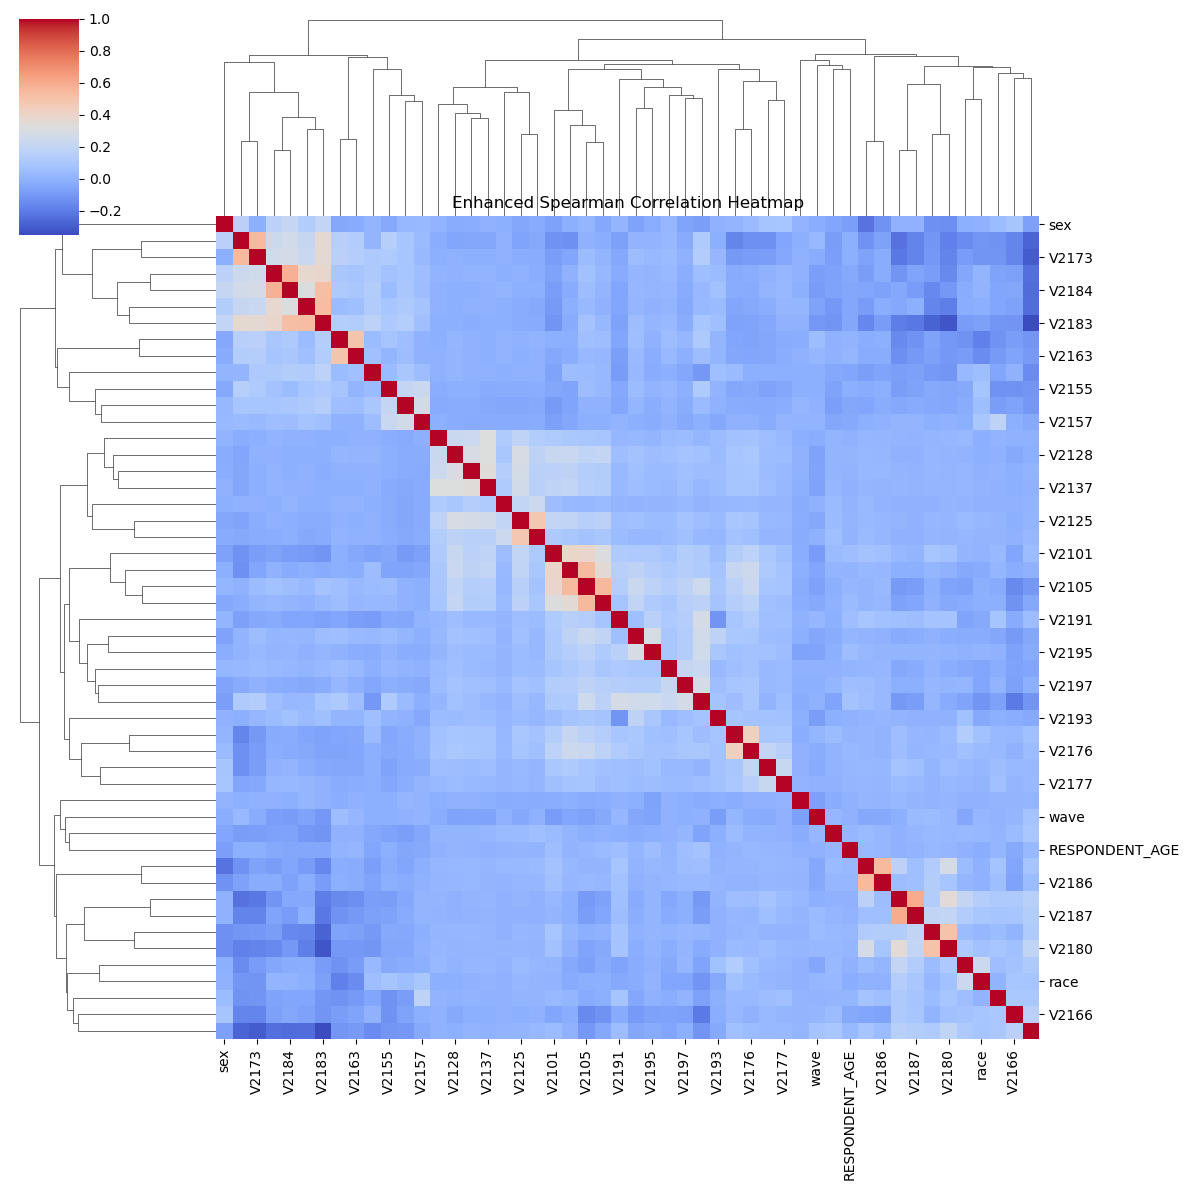


Highly correlated variable pairs (|corr| > 0.5):
  Variable1 Variable2  Correlation
0     V2179     V2173         0.54
1     V2185     V2180         0.50
2     V2188     V2183         0.53
3     V2189     V2184         0.58
4     V2182     V2187         0.60
5     V2116     V2105         0.54
6     V2181     V2186         0.54
7     V2184     V2183         0.52
8     V2105     V2108         0.54


In [33]:
# -----------------------------------------------------------------------------
# Correlation Analysis for 12th grade
# -----------------------------------------------------------------------------
print("\nData structure:")
print(new_data.info())

# Select numeric variables (excluding the target variable 'nicotine12d' if desired).
cor_vars = new_data.drop(columns=['nicotine12d'], errors='ignore').select_dtypes(include=[np.number])

# Compute the Spearman correlation matrix.
cor_matrix_spearman = cor_vars.corr(method='spearman')

# Check for non-finite values in the correlation matrix.
if not np.all(np.isfinite(cor_matrix_spearman)):
    print("\nWarning: Non-finite values detected in the correlation matrix.")
    # Replace NaN or infinite values with 0 (or another appropriate value).
    cor_matrix_spearman = cor_matrix_spearman.fillna(0)
    cor_matrix_spearman = cor_matrix_spearman.replace([np.inf, -np.inf], 0)

print("\nSpearman Correlation Matrix:")
print(cor_matrix_spearman)

# Create an enhanced heatmap with clustering.
clustergrid = sns.clustermap(cor_matrix_spearman, cmap="coolwarm", figsize=(12, 12))
clustergrid.ax_heatmap.set_title("Enhanced Spearman Correlation Heatmap")
plt.show()

# Identify highly correlated pairs (absolute correlation > 0.5 and less than 1).
high_corr_pairs = []
cols = cor_matrix_spearman.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        corr_value = cor_matrix_spearman.iloc[i, j]
        if 0.5 < abs(corr_value) < 1:
            high_corr_pairs.append({
                "Variable1": cols[i],
                "Variable2": cols[j],
                "Correlation": corr_value
            })

high_corr_df = pd.DataFrame(high_corr_pairs)
print("\nHighly correlated variable pairs (|corr| > 0.5):")
print(high_corr_df)

In [34]:
# -----------------------------------------------------------------------------
# Save the Preprocessed Data for 12th grade
# -----------------------------------------------------------------------------
# Define the path where the processed data will be saved
processed_path = "~/work/vaping_project_data/processed_data_g12nn.csv"

# Ensure the directory exists before saving the file
os.makedirs(os.path.dirname(processed_path), exist_ok=True)

# Save the preprocessed data to CSV
new_data.to_csv(processed_path, index=False)

print(f"\nProcessed data saved to '{processed_path}'.")


Processed data saved to '~/work/vaping_project_data/processed_data_g12nn.csv'.


In [37]:
# =============================================================================
# 4. Further Data Preparation and Analysis for 8th and 10th Grade
# =============================================================================

# Reload the merged data
# Define the path to the merged data file
merged_path_0810 = "~/work/vaping_project_data/merged_data_g0810.csv"

# Check if the file exists before attempting to load it
if os.path.exists(merged_path_0810):
    # Reload the merged data from the CSV file with low_memory=False
    reloaded_data_0810 = pd.read_csv(merged_path_0810, low_memory=False)
    
    # List all column names
    print("\n Data loaded as 'reloaded_data_0810'")

else:
    print(f"Error: File '{merged_path_0810}' does not exist. Please ensure the file has been saved.")


 Data loaded as 'reloaded_data_0810'


In [38]:
# -----------------------------------------------------------------------------
# Detailed Summary of Reloaded 8th and 10th Grade Data
# -----------------------------------------------------------------------------

# Basic information and missing values
print("\nReloaded 8th and 10th Grade Data Summary:")
print(f"Shape: {reloaded_data_0810.shape[0]:,} rows × {reloaded_data_0810.shape[1]:,} columns")
missing_values = reloaded_data_0810.isnull().sum()
print(f"\nMissing values: ")
print(missing_values[missing_values > 0].to_string())

# Summary statistics and outliers
print("\nSummary Statistics:")
print(reloaded_data_0810.describe().round(2))

# Categorical columns summary
print("\nCategorical Columns Summary:")
categorical_cols = reloaded_data_0810.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(reloaded_data_0810[col].value_counts().head().to_string())

# Outliers summary
print("\nOutliers Summary:")
numeric_cols = reloaded_data_0810.select_dtypes(include=[np.number]).columns
outlier_counts = {}
for col in numeric_cols:
    mean = reloaded_data_0810[col].mean()
    std = reloaded_data_0810[col].std()
    outliers = reloaded_data_0810[(reloaded_data_0810[col] > mean + 3*std) | (reloaded_data_0810[col] < mean - 3*std)]
    if len(outliers) > 0:
        outlier_counts[col] = len(outliers)
print(pd.Series(outlier_counts).to_string())



Reloaded 8th and 10th Grade Data Summary:
Shape: 156,841 rows × 496 columns

Missing values: 
sex            12154
nicotine12d    61907

Summary Statistics:
          V7233     V7510     V7569     V7718     V7426     V7243     V7479  \
count 156841.00 156841.00 156841.00 156841.00 156841.00 156841.00 156841.00   
mean      -0.45     -5.50     -5.51     -4.88     -4.06     -2.77     -1.21   
std        2.33      4.18      4.11      4.90      4.59      5.85      7.98   
min       -9.00     -9.00     -9.00     -9.00     -9.00     -9.00     -9.00   
25%        0.00     -8.00     -8.00     -8.00     -8.00     -8.00     -8.00   
50%        0.00     -8.00     -8.00     -8.00     -8.00     -8.00     -8.00   
75%        0.00      1.00      1.00      2.00      1.00      4.00      8.00   
max        1.00      5.00      7.00      3.00      5.00      4.00      8.00   

          V8518     V7215     V7540     V7386     V7139     V7380     V7459  \
count 156841.00 156841.00 156841.00 156841.00 15684

In [39]:
# -----------------------------------------------------------------------------
# Missing Data Analysis for 8th and 10th grade data
# -----------------------------------------------------------------------------

def analyze_missing_data(df):
    """Analyze missing data patterns in a DataFrame."""
    # Calculate total missing values
    total_missing = df.isna().sum().sum()
    print(f"\nTotal missing values: {total_missing:,}")
    
    # Analyze negative values in numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    negative_counts = df[numeric_cols].lt(0).sum()
    negative_summary = pd.DataFrame({
        'Column': negative_counts.index,
        'Negative_Count': negative_counts.values
    })
    print("\nNegative value counts by numeric column:")
    print(negative_summary)
    
    # Replace missing value codes with NaN
    df[numeric_cols] = df[numeric_cols].replace({-9: np.nan, -8: np.nan})
    
    # Generate comprehensive missing data summary
    missing_summary = pd.DataFrame({
        'Missing_Count': df.isna().sum(),
        'Missing_Percentage': (df.isna().mean() * 100).round(2)
    }).sort_values('Missing_Percentage', ascending=False)
    
    print("\nMissing values summary:")
    print(missing_summary.to_string())
    
    return missing_summary

# Execute analysis
missing_summary = analyze_missing_data(reloaded_data_0810)



Total missing values: 74,061

Negative value counts by numeric column:
          Column  Negative_Count
0          V7233           10584
1          V7510          113478
2          V7569          112769
3          V7718          110372
4          V7426           87938
5          V7243           81458
6          V7479           89533
7          V8518          117164
8          V7215            9385
9          V7540          113419
10         V7386          107511
11         V7139          106988
12         V7380            2753
13         V7459          121402
14         V8452          115059
15         V7438          111776
16         V7181          151461
17        V7112D            8297
18         V7481          111978
19         V7428           72080
20         V8522           95357
21         V7415           18434
22         V7115            7858
23         V7178          156635
24         V7531           92936
25         V7494           88429
26         V7167          155506
27  